In [18]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Data Loading with PyTorch**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations for the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Paths to train, validation, and test directories
data_base_dir = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames"
train_dir = os.path.join(data_base_dir, "train")
val_dir = os.path.join(data_base_dir, "val")
test_dir = os.path.join(data_base_dir, "test")

# Load datasets directly from the respective directories
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names
class_names = train_dataset.classes  # The same classes apply to all datasets
print(f"Classes: {class_names}")
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Classes: ['drowsy', 'non-drowsy']
Train size: 10931, Validation size: 3786, Test size: 4027


**Build the CNN Model**

In [ ]:
# Define the Enhanced CNN Model
class EnhancedDrowsinessCNN(nn.Module):
    def __init__(self):
        super(EnhancedDrowsinessCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x).squeeze(-1)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = EnhancedDrowsinessCNN().to(device)

# Class weights (if the dataset is imbalanced)
class_weights = 5.0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Using device: cuda


**Train the Model**

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(-1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                labels = labels.view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Collect predictions and labels for F1 score
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_preds, average="binary")  # Calculate F1 score

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Update learning rate
        scheduler.step()

    return train_losses, val_losses, val_accuracies, val_f1_scores

In [ ]:
# Train the model
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Train Loss: 0.7195, Val Loss: 0.4819, Val Accuracy: 0.8553, Val F1: 0.9217
Epoch 2/10, Train Loss: 0.4688, Val Loss: 0.3854, Val Accuracy: 0.8893, Val F1: 0.9390
Epoch 3/10, Train Loss: 0.3761, Val Loss: 0.3820, Val Accuracy: 0.9192, Val F1: 0.9547
Epoch 4/10, Train Loss: 0.3319, Val Loss: 0.3919, Val Accuracy: 0.9303, Val F1: 0.9606
Epoch 5/10, Train Loss: 0.2978, Val Loss: 0.5100, Val Accuracy: 0.9337, Val F1: 0.9621
Epoch 6/10, Train Loss: 0.2683, Val Loss: 0.5713, Val Accuracy: 0.9253, Val F1: 0.9567
Epoch 7/10, Train Loss: 0.2507, Val Loss: 0.5710, Val Accuracy: 0.9308, Val F1: 0.9598
Epoch 8/10, Train Loss: 0.2490, Val Loss: 0.5641, Val Accuracy: 0.9258, Val F1: 0.9568
Epoch 9/10, Train Loss: 0.2537, Val Loss: 0.5297, Val Accuracy: 0.9329, Val F1: 0.9612
Epoch 10/10, Train Loss: 0.2467, Val Loss: 0.4302, Val Accuracy: 0.9371, Val F1: 0.9639


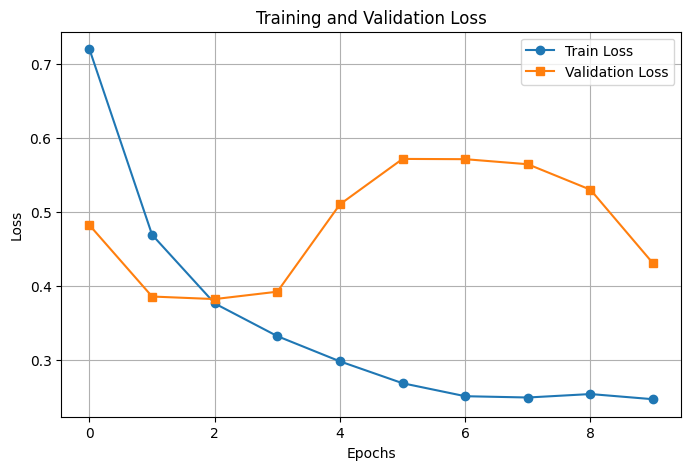

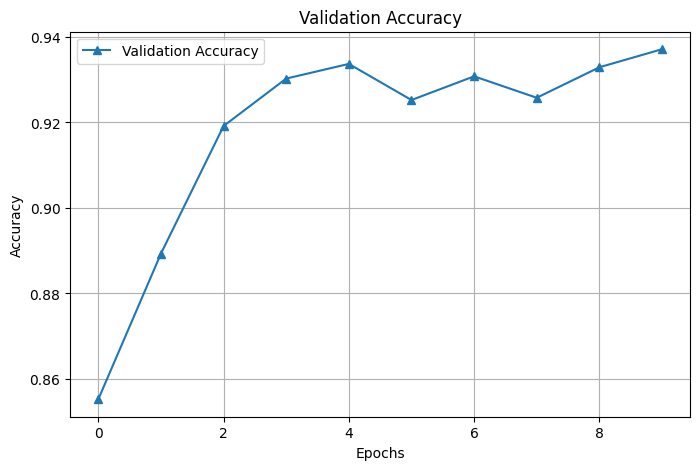

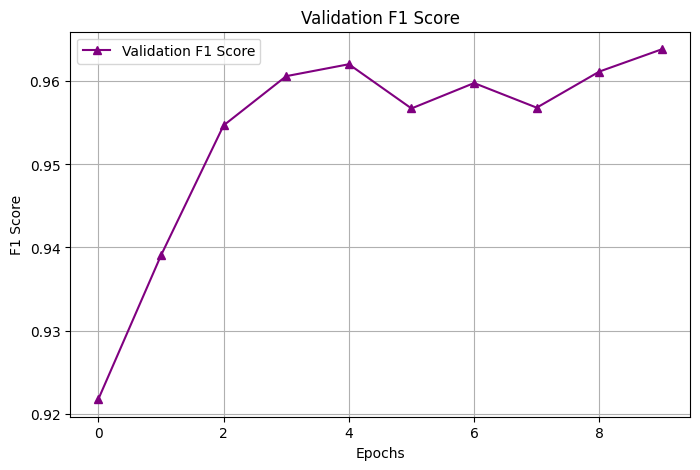

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label='Validation Accuracy', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 score
plt.figure(figsize=(8, 5))
plt.plot(val_f1_scores, label='Validation F1 Score', marker='^', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

**Save and Load the Model**

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_Final_Project/drowsiness_cnn_model.pth")

In [20]:
# Load the model for inference
model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/drowsiness_cnn_model.pth"))
model.eval()

<ipython-input-20-23c159889ec8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/drowsiness_cnn_mo

EnhancedDrowsinessCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [22]:
evaluate_model(model, test_loader)

Test Accuracy: 0.9138

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.93      0.46      0.62       610
  non-drowsy       0.91      0.99      0.95      3417

    accuracy                           0.91      4027
   macro avg       0.92      0.73      0.79      4027
weighted avg       0.92      0.91      0.90      4027



**Predict New Images**

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

def predict_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a given image using the model.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        class_names (list): List of class names.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        str: Predicted class label.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Apply transformations and add batch dimension
    image_tensor = transform(image).unsqueeze(0).to(device)  # Move to the same device as the model

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted = (output.squeeze() > 0.5).float().item()

    return class_names[int(predicted)]

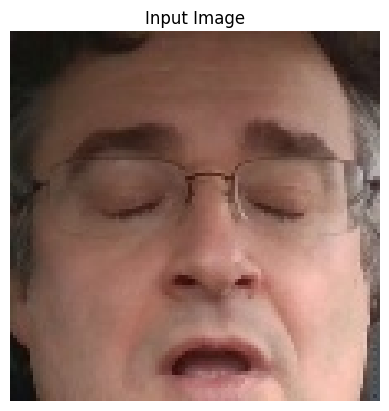

Prediction: drowsy


In [24]:
# Ensure the model and input are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_01374.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")

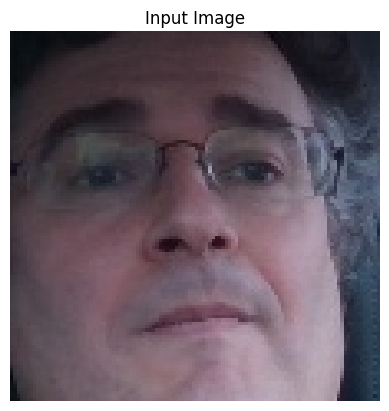

Prediction: non-drowsy


In [25]:
# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/non-drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_00009.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")